In [148]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import interp
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics, model_selection
import os
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(style="ticks", context="poster")
dirpath = os.getcwd()
print(dirpath)

/Users/jorgetil/Astro/tutorials/student_workshop_17


In [30]:
def conf_matrix(true, predict, classes, normalized=True, cl_names=None):
    '''
    function to plot confusion matrix
    '''
    cm = metrics.confusion_matrix(true, predict, labels=classes)
    plt.figure(figsize=(7,5))
    if normalized:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt='0.3f', linewidths=.5, 
                    xticklabels=cl_names, yticklabels=cl_names, cmap="GnBu", 
                    annot_kws={'size': 'medium'})
    else:
        sns.heatmap(cm, annot=True, fmt='f', linewidths=.5, 
                    xticklabels=cl_names, yticklabels=cl_names, cmap="GnBu", 
                    annot_kws={'size': 'x-large'})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix classifier')
    plt.show()

In [36]:
def PR_ROC_curves(sample, y_score, classes, fontsize=24, cl_names=None):
    '''
    function to plot ROC and PR curves
    '''
    import matplotlib.cm as cm
    # matrix with labels, shape (n_obj,n_class)
    y_test = np.zeros(y_score.shape, dtype = int)
    classes = np.asarray(classes)
    #print y_test
    #print classes
    for k in range(len(y_test)):
        mask = sample[k] == classes
        y_test[k,mask] = 1
    #print y_test
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
        average_precision[i] = metrics.average_precision_score(y_test[:, i],
                                                               y_score[:, i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    # Compute micro-average P-R curve and ROC area
    precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(y_test.ravel(),
                                                                    y_score.ravel())
    average_precision["micro"] = metrics.average_precision_score(y_test, y_score,
                                                     average="micro")

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= float(len(classes))

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    
    # Plot all P-R and ROC curves
    fig, ax = plt.subplots(ncols=2,figsize = (20,8))
    ax[0].plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = %.4f)' 
             % (roc_auc["micro"]), linewidth=4, color='b')
    ax[1].plot(recall["micro"], precision["micro"],
         label='micro-average Precision-recall curve (area = %.2f)'
               % (average_precision["micro"]), linewidth=4, color='b')

    ax[0].plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = %.4f)'
             % (roc_auc["macro"]), linewidth=4, color='g')
    
    colors = cm.Dark2(np.linspace(0, 1, len(classes)))
    for i in range(len(classes)):
        ax[0].plot(fpr[i], tpr[i], label='ROC curve of class %s (area = %.4f)'
                    % (cl_names[i], roc_auc[i]), linewidth=2, color=colors[i])
        ax[1].plot(recall[i], precision[i], label='P-R curve of class %s (area = %.4f)'
                    % (cl_names[i], average_precision[i]), linewidth=2, color=colors[i])

    ax[0].plot([0, 1], [0, 1], 'k--')
    #plt.xlim([0.0, 0.4])
    #plt.ylim([0.6, 1.05])
    ax[0].set_xlabel('False Positive Rate', fontsize='large')
    ax[0].set_ylabel('True Positive Rate', fontsize='large')
    ax[0].set_title('ROC curves to multi-class', fontsize='large')
    ax[0].legend(loc="lower right", fontsize='x-small')
    
    #plt.xlim([0.0, 0.4])
    #plt.ylim([0.6, 1.05])
    ax[1].set_xlabel('Recall', fontsize='large')
    ax[1].set_ylabel('Precision', fontsize='large')
    ax[1].set_title('Extended Precision-Recall curves to multi-class', fontsize='large')
    ax[1].legend(loc="lower left", fontsize='x-small')
    
    plt.show()

In [10]:
df = pd.read_csv("%s/data/SDSS_all_classes_21.csv" % (dirpath))
df = df.sample (20000)
print(df.info())

u, g, r, i, z = df["u_mag"].values, df["g_mag"].values, df["r_mag"].values, df["i_mag"].values, df["z_mag"].values
colors = np.array([u - g, g - r, r - i, i - z]).transpose()
print(colors.shape)
names = np.array(["u - g", "g - r", "r - i", "i - z"])
classes = np.array(df['class'])
cl_names = ["star", "quasar", "white dwarf"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1311 to 78979
Data columns (total 7 columns):
class      20000 non-null int64
u_mag      20000 non-null float64
g_mag      20000 non-null float64
r_mag      20000 non-null float64
i_mag      20000 non-null float64
z_mag      20000 non-null float64
max_mag    20000 non-null float64
dtypes: float64(6), int64(1)
memory usage: 1.2 MB
None
(20000, 4)


In [11]:
df.describe()

,class,u_mag,g_mag,r_mag,i_mag,z_mag,max_mag
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,2.050000,19.357252,19.023387,18.870971,18.761142,18.701340,19.40965
std,0.411471,1.086487,1.126354,1.175515,1.195183,1.221014,1.05998
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,18.914000,18.616000,18.501000,18.393000,18.304000,18.96200
50%,2.000000,19.420000,19.151000,19.013000,18.908000,18.831000,19.45650
75%,2.000000,19.969000,19.635000,19.474250,19.366000,19.328000,20.02700
max,3.000000,21.000000,20.969000,20.821000,20.980000,20.995000,21.00000


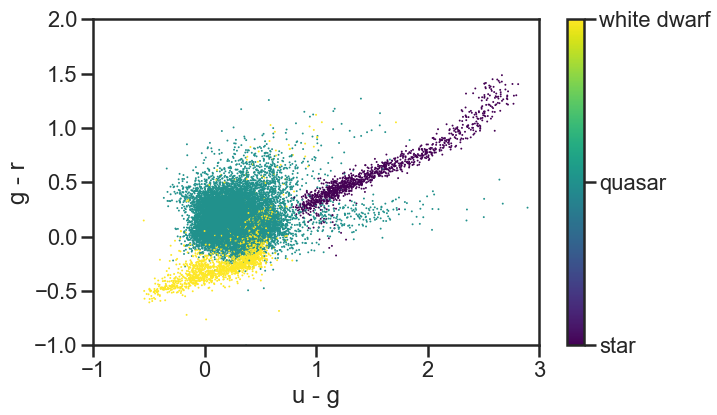

In [29]:
# fig = plt.figure(figsize = (10, 6))
# ax = fig.gca(projection='3d')
fig, ax = plt.subplots(figsize = (10, 6))

# scat = ax.scatter(colors[:, 0], colors[:, 1], colors[:, 2], c=classes,
#           cmap=cm.viridis, s=15, marker='.', edgecolors='none')
scat = ax.scatter(colors[:, 0], colors[:, 1], c=classes,
                  cmap=cm.viridis, s=15, marker='.', edgecolors='none')
cbar = fig.colorbar(scat, ticks=[1,2,3])
cbar.ax.set_yticklabels(cl_names)
ax.set_xlim(-1., 3.)
ax.set_ylim(-1, 2)
# ax.set_zlim3d(-1.5, 1)
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
# ax.set_zlabel(names[2])
plt.colormaps()
plt.show()

# A summary of scoring metrics

<img src="images/table.png">

* **Accuracy**: If $y'$ is the predicted value of the $i$-th sample and $y_{i}$ is the corresponding true value, then the fraction of correct predictions over $n_{samples}$ is defined as
$$ acc(y, y') = \frac{1}{n_{samples}} \sum_{i=0}^{n_{samples}-1}{1(y'_{i}=y{i})}$$


* **FPR**: False positive rate (fall-out)
$$ FPR = \frac {FP}{FP + TN}$$


* **TPR**: True Positive Rate (sensitivity or **recall**)
$$ TPR = \frac{TP}{TP + FN} $$


* **Precision**: Positive Predictive Value
$$ PPV = \frac  {TP}{TP + FP} $$


* **ROC**: Receiver Operating Characteristic, illustrates the performance of a binary classifier model as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.


* **PR curve**, a precision-recall curve from the ground truth label and a score given by the classifier by varying a decision threshold.


* **AUC**: Area Under the Curve of ROC curve


* **Confusion Matrix**, by definition a confusion matrix C is such that $C_{i, j}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$.

* The **F1-score** can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

$$F1 = 2* \frac{precision*recall}{precision + recall}$$


### In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. 

* *'micro'*: Calculate metrics globally by counting the total true positives, false negatives and false positives.

* *'macro'*: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

* *'weighted'*: Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

For more information on different metrics read [sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#).

# Cross-validation

To avoid overfiting, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set [X_test, y_test].

## train_test_split
<img src="images/train_test.png">

## K-fold
<img src="images/kFold.png" width="600">

## Shuffle & Split
<img src="images/ShuffleSplit.png" width="600">

## Stratified
 
 The relative class frequencies is approximately preserved in each train and validation.
 
 ### StratifiedKFold 
 <img src="images/StratifiedKFold.png" width="600">
 
 ### StratifiedShuffleSplit
 <img src="images/StratifiedShuffleSplit.png" width="600">
 
For more information see [sklearn](https://scikit-learn.org/stable/modules/cross_validation.html).

## Lets do the same but now with a Random Forest

### RFC

A [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. 
* The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).
* Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size equal to a desired maximum number of features.

<img src="images/rfc.jpg">

### Size of the TS?

In [83]:
from sklearn.ensemble import RandomForestClassifier

N_test = 2000
# array of train sizes
Ns = 2**np.arange(5, 15)
print("Ns = ", Ns)
scores = np.zeros(len(Ns))
stds = np.zeros(len(Ns))
start_time = time()
rf_clf = RandomForestClassifier()
for i in range(len(Ns)):
    N = Ns[i]
    ss = model_selection.StratifiedShuffleSplit(5,
                                                test_size=N_test,
                                                train_size=N)
    scores_i = model_selection.cross_val_score(rf_clf, data_svm,
                                               classes, cv=ss, 
                                               n_jobs=3, verbose=1)
    scores[i] = scores_i.mean()
    stds[i] = scores_i.std()

print('Time elapsed: %f sec' % (time()-start_time))

Ns =  [   32    64   128   256   512  1024  2048  4096  8192 16384]


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

Time elapsed: 5.886383 sec


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.3s finished


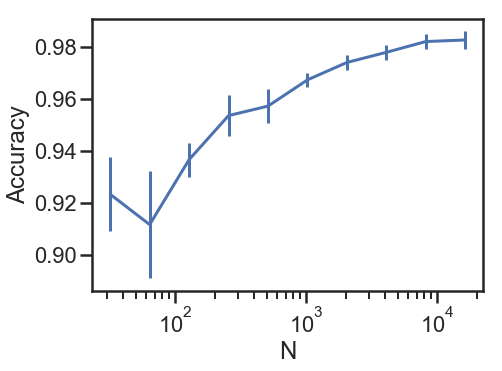

In [84]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1,1,1)
ax.errorbar (Ns, scores, yerr = stds)
ax.set_xscale("log")
ax.set_xlabel("N")
ax.set_ylabel("Accuracy")
plt.show()

### How many estimators (trees in the forest)? 

In [146]:
N_test = 2000
N_train = 2048
# array of train sizes
N_est = np.arange(0,50,5)
N_est[0] = 1
print("N estimators = ", N_est)
scores = np.zeros(len(N_est))
stds = np.zeros(len(N_est))
oob_error = np.zeros(len(N_est))
start_time = time()

for i in range(len(N_est)):
    N = N_est[i]
    rf_clf = RandomForestClassifier(n_estimators=N, oob_score=True)
    ss = model_selection.StratifiedShuffleSplit(5,
                                                test_size=N_test)
    scores_i = model_selection.cross_val_score(rf_clf, data_svm,
                                               classes, cv=ss, 
                                               n_jobs=3, verbose=1)
    scores[i] = scores_i.mean()
    stds[i] = scores_i.std()
    rf_clf.fit(X_train, y_train)
    oob_error[i] = 1 - rf_clf.oob_score_

print('Time elapsed: %f sec' % (time()-start_time))

N estimators =  [ 1  5 10 15 20 25 30 35 40 45]


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   

Time elapsed: 27.540228 sec


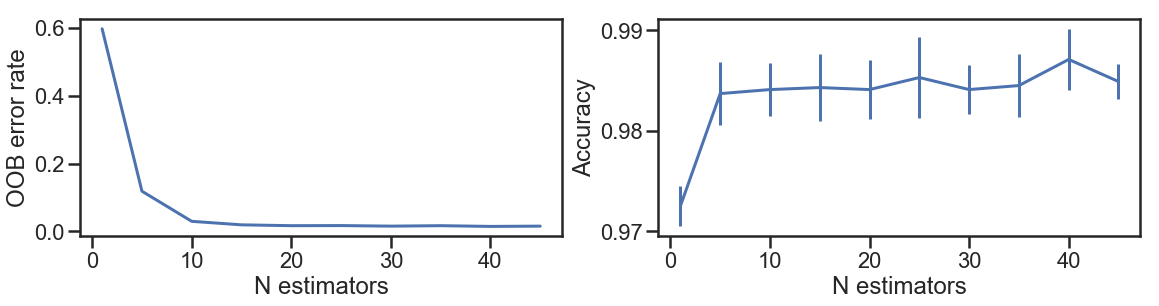

In [149]:
fig, ax = plt.subplots(1,2,figsize=(19, 4))
ax[0].plot(N_est, oob_error)
ax[0].set_xlabel("N estimators")
ax[0].set_ylabel("OOB error rate")
ax[1].errorbar (N_est, scores, yerr = stds)
ax[1].set_xlabel("N estimators")
ax[1].set_ylabel("Accuracy")
plt.show()

### Depth of the trees?

In [153]:
N_test = 2000
N_train = 2048
# array of train sizes
max_depth = list(range(0, 30, 5))
max_depth[0] = 1
max_depth[-1] = None
print("Max depth = ", max_depth)
scores = np.zeros(len(max_depth))
stds = np.zeros(len(max_depth))
oob_error = np.zeros(len(max_depth))
start_time = time()

for i,md in enumerate(max_depth):
    md = max_depth[i]
    rf_clf = RandomForestClassifier(n_estimators=15,
                                    oob_score=True,
                                    max_depth=md)
    ss = model_selection.StratifiedShuffleSplit(5,
                                                test_size=N_test,)
    scores_i = model_selection.cross_val_score(rf_clf, data_svm,
                                               classes, cv=ss, 
                                               n_jobs=3, verbose=1)
    scores[i] = scores_i.mean()
    stds[i] = scores_i.std()
    rf_clf.fit(X_train, y_train)
    oob_error[i] = 1 - rf_clf.oob_score_

print('Time elapsed: %f sec' % (time()-start_time))

Max depth =  [1, 5, 10, 15, 20, None]


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.0s finished


Time elapsed: 6.964797 sec


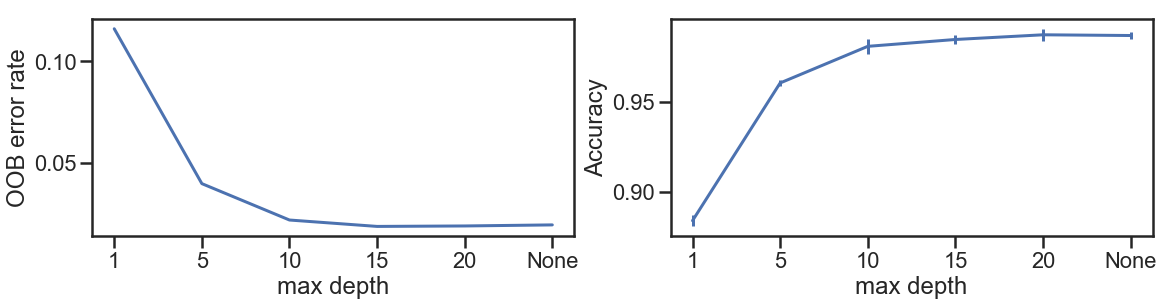

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(19, 4))
max_depth = [str(x) for x in max_depth]
ax[0].plot(max_depth, oob_error)
ax[0].set_xlabel("max depth")
ax[0].set_ylabel("OOB error rate")

ax[1].errorbar (max_depth, scores, yerr=stds)
ax[1].set_xlabel("max depth")
ax[1].set_ylabel("Accuracy")
plt.show()

### What about other parameters?

In [168]:
# split data with Stratified Shuffle Split
ss = model_selection.StratifiedShuffleSplit(5,
                                            test_size=N_test)
# Grid of params for RF
param_grid = {"max_depth": [10],
              "max_features": [None,'sqrt','log2'],
              "min_samples_split": [2,4,8],
              "min_samples_leaf": [1,3,5],
              "bootstrap": [True],
              "criterion": ["gini", "entropy"],
              "n_estimators": [15,20,25],
              "class_weight": ['balanced_subsample', 'balanced']}

# initialize RFC
rf_clf = RandomForestClassifier()
# initialize grid search
grid_search = model_selection.GridSearchCV(rf_clf, 
                                           param_grid=param_grid, 
                                           cv=ss,
                                           n_jobs=4, verbose=1)
start_time = time()
# fit data
grid_search.fit(data_svm, classes)

print("The best classifier is: ", grid_search.best_estimator_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  7.2min
[Parallel(n_jobs=4)]: Done 1620 out of 1620 | elapsed:  9.2min finished


The best classifier is:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=10, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


In [185]:
best_rf_clf = grid_search.best_estimator_

sss = model_selection.StratifiedShuffleSplit(5,
                                             test_size=N_test)
skf = model_selection.StratifiedKFold(n_splits=5)

# Play with cross validation method: [sss, skf]
scores_f = model_selection.cross_val_score(best_rf_clf, data_svm,
                                           classes, scoring='f1_macro', 
                                           cv=skf,
                                           n_jobs=2, verbose=1)
prediction = model_selection.cross_val_predict(best_rf_clf, data_svm,
                                               classes, cv=skf, n_jobs=2, 
                                               verbose=1)
prediction_prob = model_selection.cross_val_predict(best_rf_clf, data_svm,
                                                    classes, cv=skf, n_jobs=2, 
                                                    verbose=1,
                                                    method='predict_proba')

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.5s finished


In [176]:
print ("Accuracy = ", scores_f.mean(), "+-", scores_f.std())
print ('F1-score in test set: \t%f' % (metrics.f1_score(classes,
                        prediction, average='macro',labels=[1,2,3])))
print (metrics.classification_report(classes, prediction))

Accuracy =  0.9671931767626732 +- 0.002267659551468662
F1-score in test set: 	0.967352
              precision    recall  f1-score   support

           1       0.96      0.98      0.97      1218
           2       0.99      0.99      0.99     16564
           3       0.94      0.94      0.94      2218

   micro avg       0.98      0.98      0.98     20000
   macro avg       0.96      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



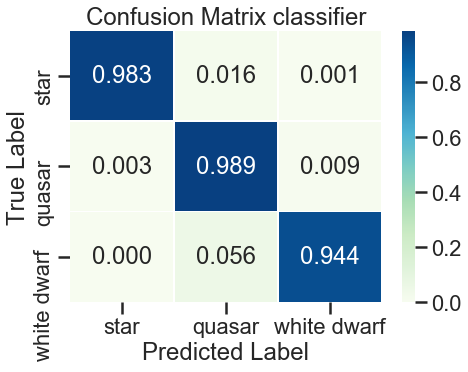

In [177]:
conf_matrix(classes, prediction, [1,2,3], cl_names=cl_names)

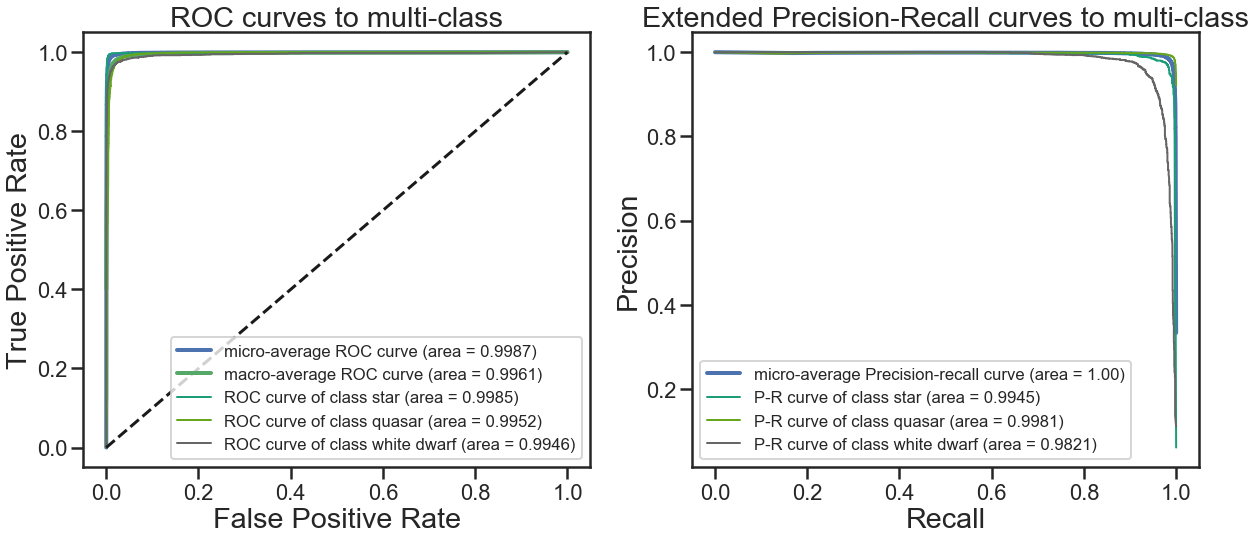

In [187]:
PR_ROC_curves(classes, prediction_prob, [1,2,3], cl_names=cl_names)

Now we have a good RF classifier. Lets use it over the unlabeled data.

In [178]:
#train on all the data
best_rf_clf.fit(data_svm, classes)

# load unlabeled data
data_ul = np.genfromtxt("%s/data/SDSS_colors.csv" % (dirpath),
                        delimiter=',', skip_header = 1)
u, g, r, i, z = data_ul[:, 0], data_ul[:, 1],\
                data_ul[:, 2], data_ul[:, 3], data_ul[:, 4]
colors_ul = u - g, g - r, r - i, i - z
data_ul = np.array(colors_ul).transpose()
print ('size of training set: ', data_svm.shape)
print ("size of target set: ", data_ul.shape)

# predict
pred_class = best_rf_clf.predict(data_ul)

out = np.zeros((len(pred_class), data_ul.shape[1] + 1))
out[:,:data_ul.shape[1]] = data_ul[:][:]
out[:, -1] = pred_class [:]
np.savetxt("classifications.csv", out, delimiter=",")

size of training set:  (20000, 4)
size of target set:  (12884, 4)


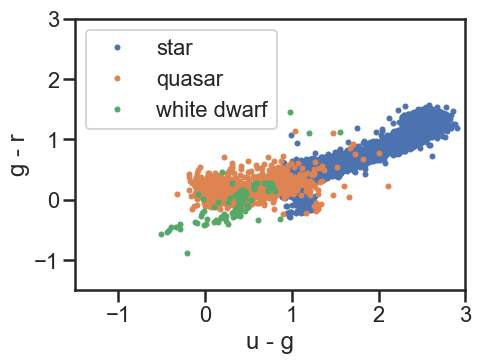

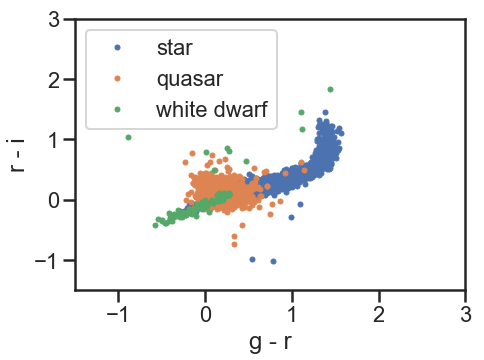

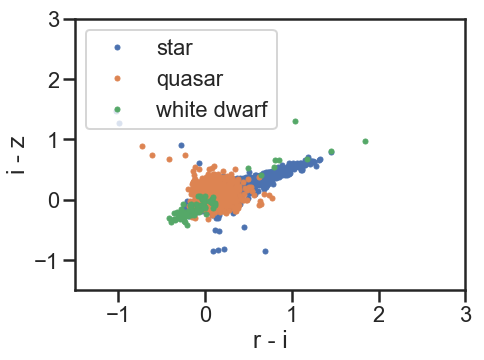

In [179]:
for i in range(3):
    plt.figure(figsize=(7,5))
    for cl in np.arange(1, 4):
        criteria = (pred_class == cl)
        plt.plot(colors_ul[i][criteria], colors_ul[i+1][criteria],
                "o", markersize=5, label=cl_names[cl-1])

    plt.xlabel (names[i])
    plt.ylabel (names[i+1])
    plt.legend (loc = "upper left")
    plt.xlim([-1.5, 3])
    plt.ylim([-1.5, 3])
    plt.show()

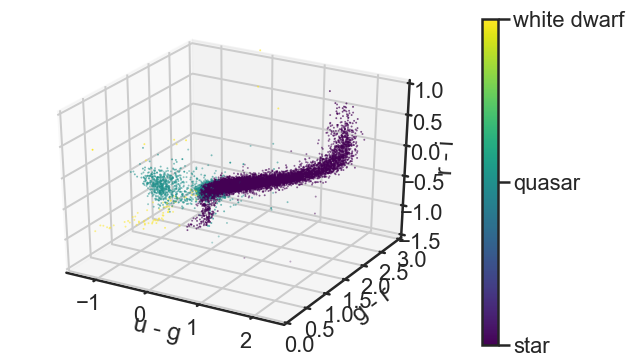

In [180]:
fig = plt.figure(figsize = (10, 6))
ax = fig.gca(projection='3d')
scat = ax.scatter(colors_ul[0], colors_ul[1], colors_ul[2], 
                  c=pred_class, cmap=cm.viridis, s=15, 
                  marker='.', edgecolors='none')
cbar = fig.colorbar(scat, ticks=[1,2,3])
cbar.ax.set_yticklabels(cl_names)
ax.set_xlim3d(-1.5, 2.5)
ax.set_ylim3d(0, 3)
ax.set_zlim3d(-1.5, 1)
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_zlabel(names[2])
plt.colormaps()
plt.show()

# SVM

More formally, a support vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks. 

In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.

In [32]:
from sklearn import svm

# split full data-set into train and test
data_svm = colors
X_train, X_test, y_train, y_test = \
       model_selection.train_test_split (data_svm, classes,
                                          test_size=1./3.)

print("training set = ", X_train.shape, y_train.shape)
print("test size = ", X_test.shape, y_test.shape)

svm_clf = svm.LinearSVC()
svm_clf.fit(X_train, y_train)

svm_pred_class = svm_clf.predict(X_test)

acc = svm_clf.score(X_test, y_test)
print("Accuracy = %f" % acc)
print('F1_score(micro) = %f' % (metrics.f1_score(y_test,
                                    svm_pred_class,
                                    average='micro',labels=[1,2,3])))
print('F1_score(macro) = %f' % (metrics.f1_score(y_test,
                                    svm_pred_class,
                                    average='macro',labels=[1,2,3])))
print('F1_score(weighted) = %f' % (metrics.f1_score(y_test,
                                    svm_pred_class,
                                    average='weighted',labels=[1,2,3])))

print(metrics.classification_report(y_test, svm_pred_class))

svm_pred_prob = svm_clf.decision_function(X_test)
svm_pred_prob = (svm_pred_prob - svm_pred_prob.min()) / \
               (svm_pred_prob.max() - svm_pred_prob.min())

training set =  (13333, 4) (13333,)
test size =  (6667, 4) (6667,)
Accuracy = 0.944803
F1_score(micro) = 0.944803
F1_score(macro) = 0.871082
F1_score(weighted) = 0.941494
              precision    recall  f1-score   support

           1       0.84      0.89      0.87       384
           2       0.95      0.99      0.97      5563
           3       0.98      0.65      0.78       720

   micro avg       0.94      0.94      0.94      6667
   macro avg       0.92      0.84      0.87      6667
weighted avg       0.95      0.94      0.94      6667



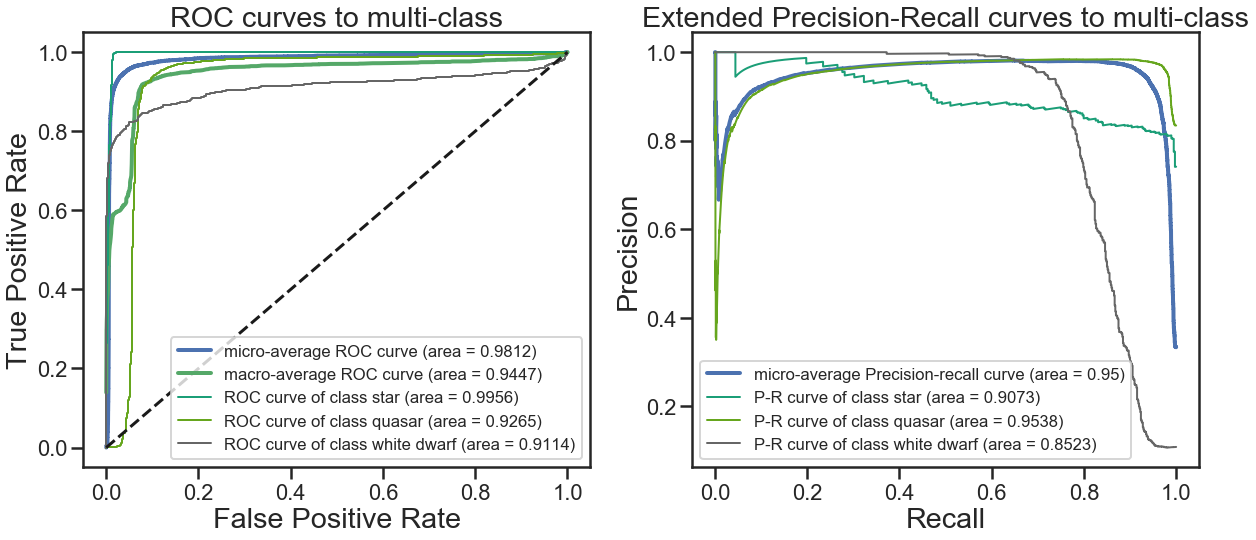

In [37]:
PR_ROC_curves(y_test, svm_pred_prob, [1,2,3], cl_names=cl_names)

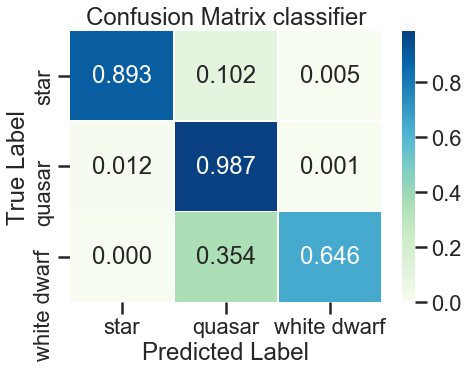

In [38]:
conf_matrix(y_test, svm_pred_class, [1,2,3], cl_names=cl_names)

Much better, isn’t it?
But is it possible that we obtained these results by chance?

In [195]:
ss = model_selection.StratifiedKFold(10)
scores = model_selection.cross_val_score(svm_clf, data_svm, classes, 
                                         scoring='accuracy',
                                         cv=ss, n_jobs=2, verbose=2)
print("Accuracy = ", scores.mean(), "+-", scores.std())

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy =  0.9440500089294691 +- 0.0039767399828488014


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.3s finished


That’s great!! Though it took 'long'.

Can we achieve better results by getting more data? Or maybe we’re using more data than needed.

In [50]:
N_test = 2000
# array of train sizes
Ns = 2**np.arange(5, 15)
print("Ns = ", Ns)
scores = np.zeros(len(Ns))
stds = np.zeros(len(Ns))
for i in range(len(Ns)):
    N = Ns[i]
    ss = model_selection.StratifiedShuffleSplit(10, test_size=N_test, train_size=N)
    scores_i = model_selection.cross_val_score(svm_clf, data_svm,
                                                classes, cv=ss, n_jobs=2, verbose=1)
    scores[i] = scores_i.mean()
    stds[i] = scores_i.std()

Ns =  [   32    64   128   256   512  1024  2048  4096  8192 16384]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   

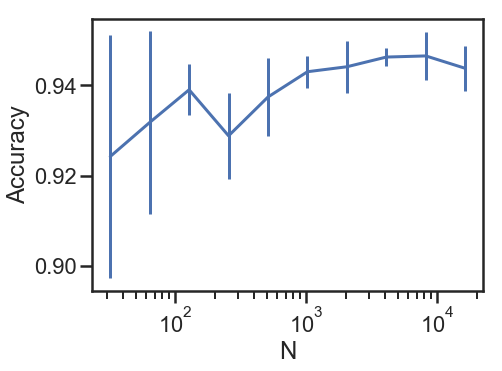

In [51]:
plt.figure(figsize=(7,5))
plt.errorbar (Ns, scores, yerr = stds)
plt.xscale("log")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.show()

Can I do better? Recall SVMs:

$\min_{\bf{w}, \xi, b}\left\{\frac{1}{2}||\bf{w}||^2 + C\sum_{i=1}^n\xi_i\right\}$

C penalty parameter C of the error term.
What value for C shall we use? The default is 1.

In [72]:
N_train = 1000
N_test = 1000

C_range = 10. ** np.arange(-5, 10)
param_grid = dict(C=C_range)
ss = model_selection.StratifiedShuffleSplit(10, 
                                            test_size=N_test,
                                            train_size=N_train)

grid = model_selection.GridSearchCV(svm.LinearSVC(), 
                                    param_grid=param_grid, 
                                    cv=ss,
                                    n_jobs=2, verbose=1,
                                    return_train_score=True)

grid.fit(data_svm, classes)
print("The best classifier is: ", grid.best_estimator_)

# grid_scores_ contains parameter settings and scores 
score_dict = grid.cv_results_

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    3.7s finished


The best classifier is:  LinearSVC(C=100.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


/Users/jorgetil/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


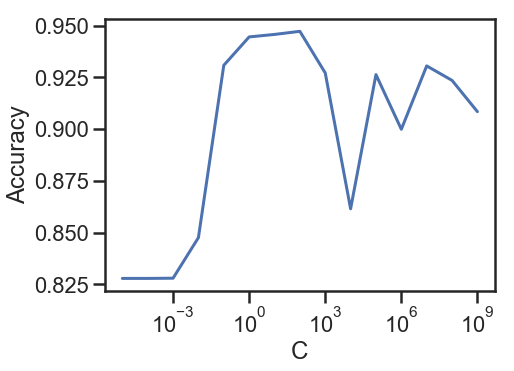

In [74]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
ax.errorbar(C_range, score_dict['mean_train_score'])
ax.set_xscale("log")
ax.set_xlabel("C")
ax.set_ylabel("Accuracy")
plt.show ()

#### Using an RBF Kernel
Radial Basis Function Kernel

$K(\bf{x}, \bf{x}') = e^{-\gamma||\bf{x}-\bf{x}'||^2}$
   
Now we have to choose C and $\gamma$!!!

In [78]:
C_range = 10. ** np.arange(-4, 4)
gamma_range = 10. ** np.arange(-4, 4)

param_grid = dict(gamma=gamma_range, C=C_range)

grid = model_selection.GridSearchCV(svm.SVC(kernel="rbf"), 
                                    param_grid=param_grid,
                                    cv=ss, n_jobs=2, 
                                    verbose=1,
                                    return_train_score=True)
grid.fit(data_svm, classes)

print("The best classifier is: ", grid.best_estimator_)
score_dict = grid.cv_results_

# We extract the scores
scores = score_dict['mean_train_score']
print(np.array(scores).shape)
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 340 tasks      | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done 640 out of 640 | elapsed:   14.6s finished


The best classifier is:  SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
(64,)


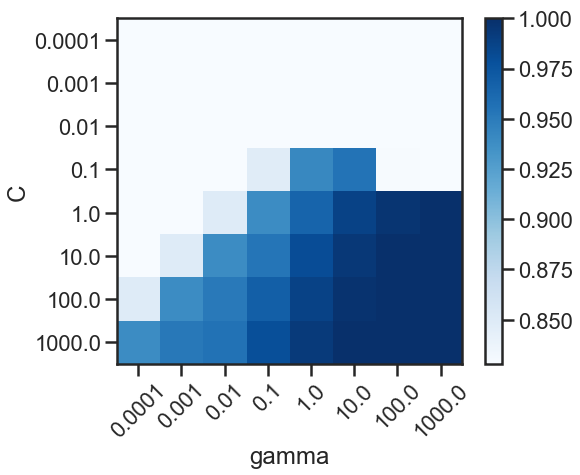

In [79]:
# Make a nice figure
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap='Blues')
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()